# Баесовские Модели: Нормализация Данных и Квадратичная Функция ошибки

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid'])

Попытаемся обучить обручную линейную регрессию $x \cdot w_0+x^2 \cdot w_1+ b = y \ \Rightarrow \ Xw = y$, в качестве функции ошибки возьмем среднее квадратов отклонений $MSE = E[\ \|Xw-y\|^2\ ]$

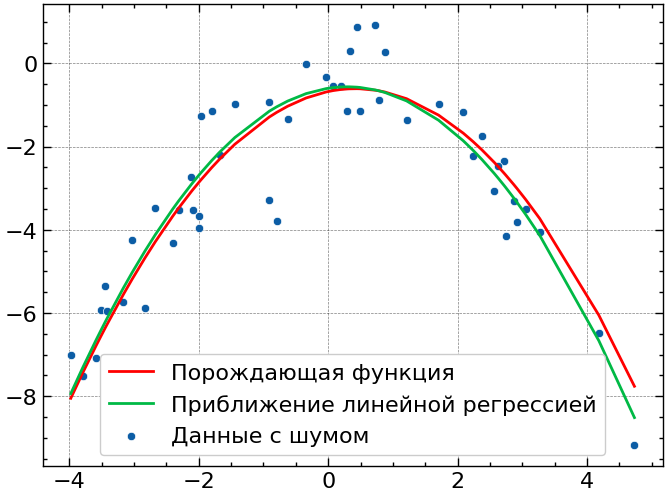

In [2]:
np.random.seed(42)

n = 50
# Создаем двумерный массив x с двумя столбцами: первый столбец - линейное пространство с шумом, второй - единицы
X = np.linspace(-4, 4, n).reshape(-1, 1) + np.random.randn(n,1)
X = np.hstack([X, X**2, np.ones((n, 1))])

# Генерируем вектор весов w и вектор шума epsilon
w = np.random.randn(3, 1)
epsilon = np.random.randn(n, 1)

# Вычисляем y как линейную комбинацию x и w с добавлением шума epsilon
y = X @ w + epsilon

w_mse = np.linalg.inv(X.T@X)@X.T@y

# Строим прямую из которой порождались точки
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X[:, 0], y=(X @ w_mse)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')

# Строим точки данных
sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

plt.show()

In [3]:
w_mse

array([[ 0.23907294],
       [-0.40426246],
       [-0.59872844]])

In [4]:
import tensorflow as tf

X_tensor = tf.constant(X, dtype=tf.float32) 
y_tensor = tf.constant(y, dtype=tf.float32)

model = tf.keras.Sequential([ tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False) ])

model.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

model.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

C:\Python\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model.get_weights()

[array([[ 0.2406406 ],
        [-0.40393934],
        [-0.59209925]], dtype=float32)]

Можно посмотреть на графике как она обучается

![training](assets/training_2.gif)

Попробуем разложить $MSE$ по компонентам:
<br>
Так как $E[X^2] = Var[X] + E[X]^2$
<br>
Средняя квадратичная ошибка:
<br>
$MSE = E[(\hat{y} - y)^2] = Var[\hat{y} - y] + E[\hat{y}-y]^2 = Var[\hat{y} - f(x)] + E[\hat{y}-f(x)]^2 + Var[\epsilon]$
<br>
$MSE = Var[\hat{y} - f(x)] + Bias^2 + Error^2$

Если мы обручем модель только на $Var[\hat{y}-y]$ тогда у нас обучаются только веса $w_i$, которые отвечают за наклон гиперплоскости в линейном пространстве, и смещение никак не влияет на ошибку, так как $Var[x+const]= Var[x] \ \Rightarrow \ Var[\hat{y}-y] = Var[Xw+ b-y]= Var[Xw -y] $
<br>
<br>
$Var_X[Xw -y] = E_X[\ \|Xw - y - E_X[Xw - y]\ \|^2\ ]= \frac{1}{m} \|Xw - y- (\mu_x\mu_x^Tw - \mu_y I)\|^2=\frac{1}{m}((X- \mu_x\mu_x^T)w - y- \mu_y I)^T((X- \mu_x\mu_x^T)w - y- \mu_y I)$
<br>
<br>
$Var_X[Xw -y] = w^T COV_Xw - 2w^T Cov_{X,y} + Var[y]$
<br>
<br>
$\nabla Var_X[Xw -y] = 2COV_Xw - 2w^T Cov_{X,y} = 0 \Rightarrow w = COV_X^{-1}Cov_{X,y}$
<br>
<br>
Где $\mu_x$ - вектор средних по столбцам $X$,

$\mu_y$ - среднее $y$, 

$I$ вектор из едениц = $\begin{bmatrix}
        \ 1 \ \\
        \ 1 \ \\
        \ \vdots \ \\
        \ 1 \ 
    \end{bmatrix}$,

$COV_X = \frac{1}{m}(X- \mu_x\mu_x^T)^T(X- \mu_x\mu_x^T)$ - матрица ковариаций по столбцам $X$,

$Cov_{X, y} = \frac{1}{m}(X- \mu_x\mu_x^T)^T(y-\mu_y)$ - вектор ковариаций каждого столбца $x$ с вектором $y$

$Var[y] = \frac{1}{m} (y- \mu_y I)^T(y- \mu_y I)$ - дисперсия $y$

In [6]:
def custom_loss_function_std(y_true, y_pred):
    return tf.math.reduce_std(y_pred - y_true)

# Модель
model_std = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False)
])

# Функция потерь и оптимизатор
model_std.compile(optimizer=tf.optimizers.RMSprop(), loss=custom_loss_function_std)

model_std.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

In [7]:
model_std.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model_std.get_weights()

[array([[ 0.2384771 ],
        [-0.40573597],
        [ 0.5000011 ]], dtype=float32)]

![training](assets/training_3.gif)

А ошибка $Bias^2 = E[\hat{y}-y]^2$ в основной части обучает смещение:
<br>
$Bias^2 = E_X[Xw-y]^2 = (\mu_x^Tw - \mu_y)^2$

$\nabla Bias^2 = 2\mu_x\mu_x^T w - 2\mu_y \mu_x = 0 \ \Rightarrow \ \mu_x^T w = \mu_y$
<br>

Что дает бесконечно много решений, и при правильных весах $w_i$ обучает правильное смещение $b$

In [8]:
def custom_loss_function_sqr_mean(y_true, y_pred):
    return tf.math.square(tf.reduce_mean(y_pred - y_true))

model_mean = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False)
])

model_mean.compile(optimizer=tf.optimizers.RMSprop(), loss=custom_loss_function_sqr_mean)

model_mean.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

In [9]:
model_mean.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model.get_weights()

[array([[ 0.2406406 ],
        [-0.40393934],
        [-0.59209925]], dtype=float32)]

![training](assets/training_4.gif)

Если подумать, то нормализуя данные ($x_i^{normal} = \frac{x_i-\mu_{x_i}}{\sigma_{x_i}}$) тогда значение $Bias^2 = E[Xw-y]^2 = (\mu_x^Tw - \mu_y)^2$ так как mu_x_i =0 и \mu_y = 0 будет всегда равно $b^2$ которое минимизируется при $b=0$ и нам не нужно больше использовать смещение, что упрощает вычисления

Более того в ошибке $Var[Xw -y] = w^T COV_Xw - 2w^T Cov_{X,y} + Var[y]$ матрицы ковариаций превращаются в матрицы корреляций, а дисперсия $y$ будет равна единице, более того марица корреляций $CORR_X= \frac{1}{m}X^TX$, $Corr_{X,y} = X^Ty$

Проверим как происходит переход между $w_{true}$ и $w_{normal}$ зная что $b_{normal}=0$ из рассуждений выше: 

\begin{align*}
    \begin{bmatrix}
            \frac{1}{\sigma_{x_1}} & 0 & \dots & 0 \\
            0 & \frac{1}{\sigma_{x_2}} & \dots & 0 \\
            \vdots & \vdots & \ddots & \vdots \\
            0 & 0 & \dots & \frac{1}{\sigma_{x_n}}
        \end{bmatrix}
        \begin{bmatrix}
            x_{11} - \mu_{x_1} & x_{12} - \mu_{x_2}& \dots & x_{1n} - \mu_{x_n} \\
            x_{21} - \mu_{x_1} & x_{22} - \mu_{x_2}& \dots & x_{2n} - \mu_{x_n} \\
            \vdots & \vdots & \ddots & \vdots \\
            x_{m1} - \mu_{x_1} & x_{m2} - \mu_{x_2}& \dots & x_{mn} - \mu_{x_n}
        \end{bmatrix}
        \begin{bmatrix}
            w_{1} \\
            w_{2} \\
            \vdots\\
            w_{n}
        \end{bmatrix} = \frac{1}{\sigma_y}
        \begin{bmatrix}
            y_{1}-\mu_y \\
            y_{2} - \mu_y \\
            \vdots\\
            y_{m} - \mu_y
        \end{bmatrix}
\end{align*}


$$\Sigma^{-1}(X-\mu_x \mu_x^T)w_{normal} = \sigma_y^{-1}(y-\mu_yI)$$

$$\sigma_y\Sigma^{-1}Xw_{normal} - \sigma_y\mu_x \mu_x^Tw_{normal} + \mu_yI = y$$   

$$Xw_{true} + b = y$$

$$w_{true} = \sigma_y \Sigma^{-1}w_{normal} \Rightarrow w_{normal} =\sigma_y^{-1}\Sigma w_{true}$$

$$b = \mu_x \mu_x^T\Sigma w_{true} + \mu_yI$$

Можно заметить что $w_{normal_i} = \frac{\sigma_{x_i}}{\sigma_{y}}w_{true_i}$  когда $\sigma_{x_i}>\sigma_y$ значения весов увеличиваются, а когда $\sigma_{x_i}<\sigma_y$, уменьшается, и при больших изначальных весовых коэффициентах $\sigma_y >> \sigma_{x_i}$, и большинсво весовых коэффициентов будут стягиватся к нулю, что ускоряет процесс машинного обучения, так как большинсво библиотек задает изначальные веса из нормального распределения вблизи 0

<Axes: >

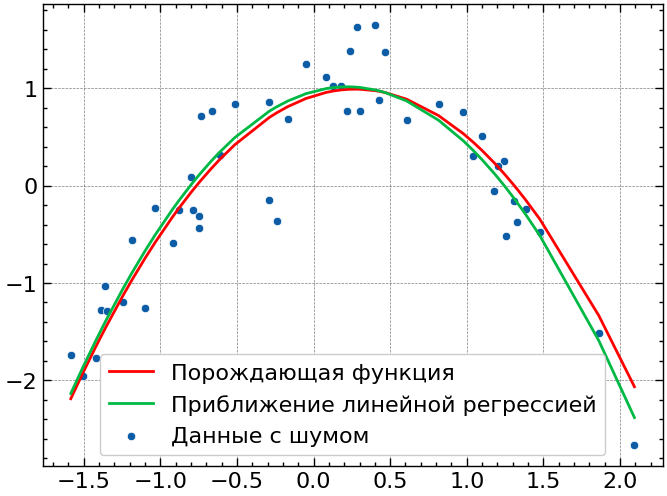

In [10]:
std_y = np.std(y)
mean_y = np.mean(y)
y_normalize = (y - mean_y)/std_y

X_normalize = np.empty((n,2))
w_normalize = np.empty((2,1))

std_x1 = np.std(X[:,0])
mean_x1 = np.mean(X[:,0])
X_normalize[:,0] = (X[:,0] - mean_x1)/std_x1

std_x2 = np.std(X[:,1])
mean_x2 = np.mean(X[:,1])
X_normalize[:,1] = (X[:,1] - mean_x2)/std_x2

std_matrix = np.array([[std_x1, 0], [0, std_x2]])

w_normalize = std_matrix @ w[:2] / std_y

w_mse_normalize = np.linalg.inv(X_normalize.T@X_normalize)@X_normalize.T@y_normalize

sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_normalize)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_mse_normalize)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')

sns.scatterplot(x=X_normalize[:, 0], y=y_normalize[:, 0], label='Данные с шумом')

In [11]:
w_mse_normalize, w_mse

(array([[ 0.24157718],
        [-0.89928582]]),
 array([[ 0.23907294],
        [-0.40426246],
        [-0.59872844]]))

In [12]:
X_tensor_normalize = tf.constant(X_normalize, dtype=tf.float32)
y_tensor_normalize = tf.constant(y_normalize, dtype=tf.float32)

model_normalize = tf.keras.Sequential([ tf.keras.layers.Dense(units=1, input_shape=(2,), use_bias=False) ])

model_normalize.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

model_normalize.set_weights(np.array([[[-0.5],[0.5]]]))

C:\Python\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model_normalize.fit(X_tensor_normalize, y_tensor_normalize, epochs=1000, verbose = False)
model_normalize.get_weights()

[array([[ 0.24156955],
        [-0.89998955]], dtype=float32)]

![training](assets/training_5.gif)

Если мы зафиксируем $X$, и будем смотреть на $\hat{y}$ как на случайную величину которая зависит от данных, тогда $f(x)$ будет фиксирован так как фиксирован $X$, взяв мат ожидание по данным получим:
<br>
<br>
$MSE = VAR_D[\hat{y} - f(x)] + E_D[\hat{y}-f(x)]^2 + VAR_D[\epsilon] = VAR_D[\hat{y} - f(x)] + Bias^2 + Error^2 = VAR_D[\hat{y}] + Bias^2 + Error^2$ 
<br>
Таким образом мы можем сравнивать различные модели при различных подходах к обучению:

Обучение полиномом первой степени:

Среднее весов: 
 [[ 0.32407762]
 [-2.85207657]]
BIAS^2:  201.2490106822
VAR:  1.8794927434651045


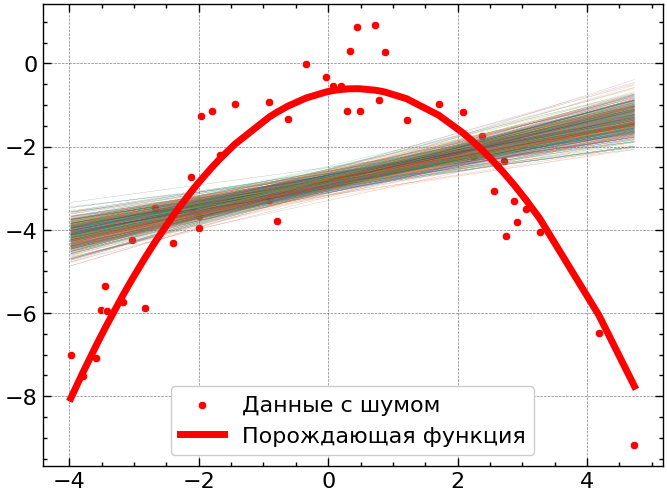

In [14]:
X_1 = X[:,0].reshape((n,1))

X_1 = np.hstack([X_1, np.ones((n, 1))])

k= 500
X_pinv = np.linalg.pinv(X_1)
w_temp_arr = np.empty((k, X_1.shape[1], 1))  

for i in range(k):
    y_temp = X@w + np.random.randn(n,1)
    w_temp = X_pinv@y_temp
    w_temp_arr[i, :] = w_temp  # Сохраняем w_temp в массиве
    sns.lineplot(x=X[:, 0], y=(X_1 @ w_temp)[:, 0], linewidth=0.1)

sns.scatterplot(x=X[:, 0], y=y[:, 0], color='r', label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=5, label='Порождающая функция')

w_temp_mean = np.mean(w_temp_arr, axis=0)
w_temp_var = np.mean(np.linalg.norm(X_1@(w_temp_arr - w_temp_mean), axis=1)**2)
print("Среднее весов: \n", w_temp_mean)
print("BIAS^2: ",np.linalg.norm(X_1@w_temp_mean - X@w)**2)
print("VAR: ", w_temp_var)

Обучение полиномом второй степени:

Среднее весов: 
 [[ 0.32662387]
 [-0.38321849]
 [-0.6883505 ]]
BIAS^2:  0.006632193179301191
VAR:  3.1522864378810285


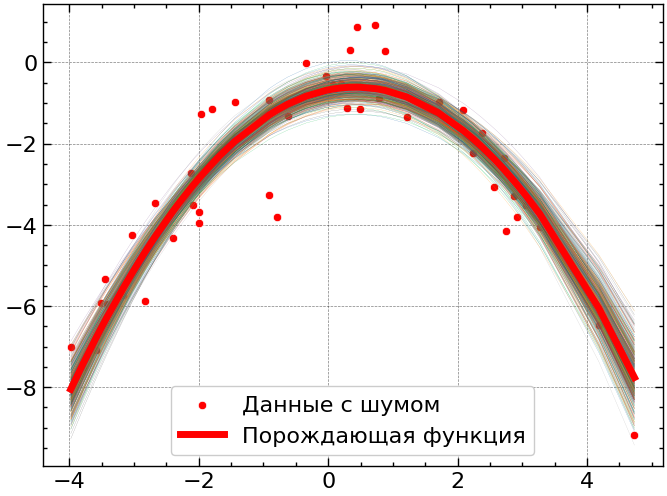

In [15]:
X_1 = X[:,0].reshape((n,1))

X_2 = np.hstack([X_1, X_1 ** 2, np.ones((n, 1))])

k= 500
X_pinv = np.linalg.pinv(X_2)
w_temp_arr = np.empty((k, X_2.shape[1], 1))  

for i in range(k):
    y_temp = X@w + np.random.randn(n,1)
    w_temp = X_pinv@y_temp
    w_temp_arr[i, :] = w_temp  # Сохраняем w_temp в массиве
    sns.lineplot(x=X[:, 0], y=(X_2 @ w_temp)[:, 0], linewidth=0.1)

sns.scatterplot(x=X[:, 0], y=y[:, 0], color='r', label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=5, label='Порождающая функция')

w_temp_mean = np.mean(w_temp_arr, axis=0)
w_temp_var = np.mean(np.linalg.norm(X_2 @ (w_temp_arr - w_temp_mean), axis=1) ** 2)
print("Среднее весов: \n", w_temp_mean)
print("BIAS^2: ", np.linalg.norm(X_2 @ w_temp_mean - X @ w) ** 2)
print("VAR: ", w_temp_var)

Обучение полиномом четвертой степени:

Среднее весов: 
 [[ 3.24629666e-01]
 [-3.84362692e-01]
 [ 2.84323654e-04]
 [-1.34164141e-04]
 [-6.68869795e-01]]
BIAS^2:  0.006690022633323337
VAR:  5.074036655003089


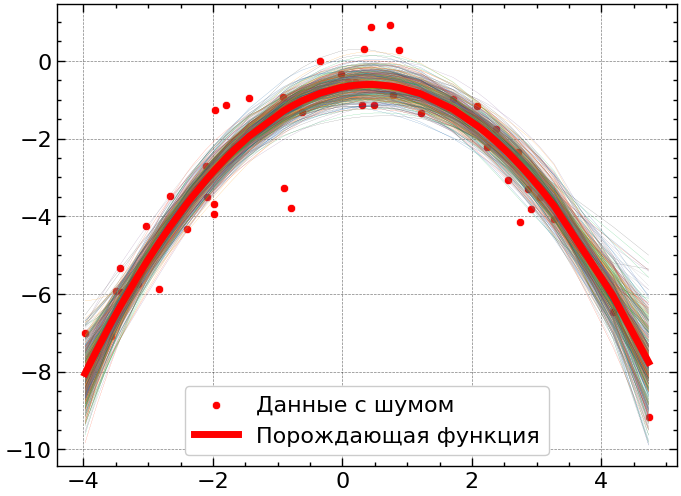

In [16]:
X_1 = X[:,0].reshape((n,1))

X_4 = np.hstack([X_1, X_1 ** 2, X_1 ** 3, X_1 ** 4, np.ones((n, 1))])

k= 500
X_pinv = np.linalg.pinv(X_4)
w_temp_arr = np.empty((k, X_4.shape[1], 1))  

for i in range(k):
    y_temp = X@w + np.random.randn(n,1)
    w_temp = X_pinv@y_temp
    w_temp_arr[i, :] = w_temp  # Сохраняем w_temp в массиве
    sns.lineplot(x=X[:, 0], y=(X_4 @ w_temp)[:, 0], linewidth=0.1)

sns.scatterplot(x=X[:, 0], y=y[:, 0], color='r', label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=5, label='Порождающая функция')

w_temp_mean = np.mean(w_temp_arr, axis=0)
w_temp_var = np.mean(np.linalg.norm(X_4 @ (w_temp_arr - w_temp_mean), axis=1) ** 2)
print("Среднее весов: \n", w_temp_mean)
print("BIAS^2: ", np.linalg.norm(X_4 @ w_temp_mean - X @ w) ** 2)
print("VAR: ", w_temp_var)

Обучение полиномом второй степени, функция ошибки MAE:

Среднее весов: 
 [[ 0.33306839]
 [-0.41433286]
 [-0.37075487]]
BIAS^2:  2.147288139636177
VAR:  5.77794215379106


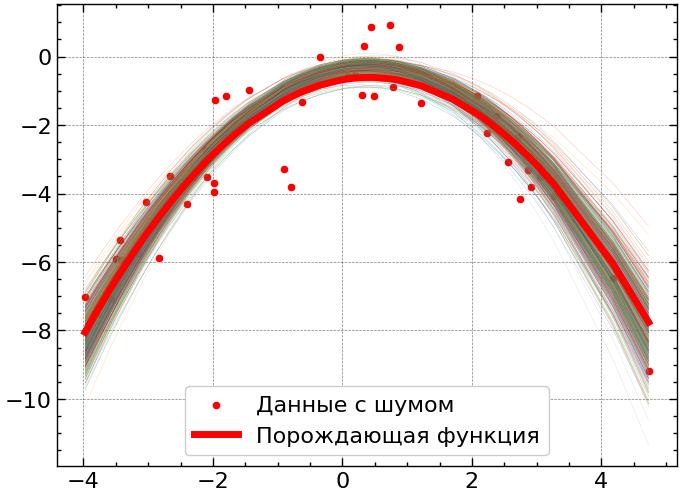

In [17]:
k= 500
sgd_reg = SGDRegressor(loss='epsilon_insensitive', epsilon=0, fit_intercept=False)
w_temp_arr = np.empty((k, X_2.shape[1], 1))  

for i in range(k):
    y_temp = X@w + np.random.randn(n,1)
    w_temp = sgd_reg.fit(X_2,y_temp.ravel()).coef_.reshape(3,1)
    w_temp_arr[i, :] = w_temp  # Сохраняем w_temp в массиве
    sns.lineplot(x=X[:, 0], y=(X_2 @ w_temp)[:, 0], linewidth=0.1)

sns.scatterplot(x=X[:, 0], y=y[:, 0], color='r', label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=5, label='Порождающая функция')

w_temp_mean = np.mean(w_temp_arr, axis=0)
w_temp_var = np.mean(np.linalg.norm(X_2 @ (w_temp_arr - w_temp_mean), axis=1) ** 2)
print("Среднее весов: \n", w_temp_mean)
print("BIAS^2: ", np.linalg.norm(X_2 @ w_temp_mean - X @ w) ** 2)
print("VAR: ", w_temp_var)

Нахождение оценок для $Var(\hat{y})$ можно получить из апостериорного распределения на веса $w$, а оценку на $Bias^2$ можно получить эмпирически как  квадрат среднего отклонения от данных $y$